In [2]:
import sys
sys.path.append('../')
import atlas

import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Exploring the output

This notebook explores some of the output of `ATLAS` and `SYNTHE` that can be parsed directly with `BasicATLAS`. Note that more data are available in the raw output found in the corresponding run directories.

We will use `~/ATLAS_sun_model` as our working directory. First, make sure the folder does not already exist:

In [3]:
rm -rf ~/ATLAS_sun_model

Now run both `ATLAS-9` to calculate the structure of the Sun and `SYNTHE` to calculate its synthetic spectrum, as demonstrated in other tutorials:

*The calculation may take a few hours*

In [4]:
run_dir = os.path.expanduser('~/ATLAS_sun_model')
atlas.atlas(run_dir)
atlas.synthe(run_dir, 200, 2600)

Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 0.177 | max[abs(de)] = 47.288
30 iterations completed: max[abs(err)] = 0.162 | max[abs(de)] = 2.574
ATLAS-9 halted

Final convergence: max[abs(err)] = 0.162 | max[abs(de)] = 2.574
Saved the model in model.dat
Finished running ATLAS-9 in 0:01:24.288796 s
Adapted the ATLAS-9 model to SYNTHE in output_synthe.out
Launcher created for wavelength range (200, 2600), batch 1. Expected number of points: 1538970 (buffer 2010001)
SYNTHE halted
Total data points: 1538970
Saved the spectrum in spectrum.dat
Finished running SYNTHE in 0:40:53.487259 s


## Structure

The profiles of physical properties throughout the model atmosphere may be parsed with `atlas.read_structure()`:

In [5]:
structure, units = atlas.read_structure(run_dir)

Here, `structure` contains the profiles themselves and `units` the corresponding physical units. Both are dictionaries with identical sets of keys:

In [6]:
structure.keys()

dict_keys(['layer', 'temperature', 'gas_pressure', 'electron_number_density', 'rosseland_opacity', 'radiative_acceleration', 'turbulent_velocity', 'radiative_flux', 'convective_speed', 'speed_of_sound', 'mass_column_density', 'density', 'physical_depth', 'rosseland_optical_depth', 'convective_flux', 'radiation_pressure', 'flux_error', 'flux_error_derivative'])

Each profile is simply a run of the corresponding quantity throughout the atmosphere, starting with the outermost layer going inwards. For example, we can plot the temperature profile as a function of physical depth:

Text(0, 0.5, 'Temperature [K]')

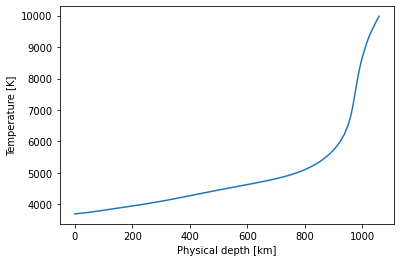

In [7]:
plt.plot(structure['physical_depth'], structure['temperature'])
plt.xlabel('Physical depth [{}]'.format(units['physical_depth']))
plt.ylabel('Temperature [{}]'.format(units['temperature']))

A converged model atmosphere must be in both hydrostatic and energy equilibrium. As an exercise, let us check that both hold. The mathematical expression for hydrostatic equilibrium reads:

$$dP=\rho g dh$$

where $dP/dh$ is the pressure gradient with respect to physical depth, $\rho$ is the density and $g$ is the gravity. In our case, gravity is a constant determined by the parameters of the model. We can use `atlas.meta()` to retrieve it:

In [8]:
g = 10 ** atlas.meta(run_dir)['logg']       #  Convert to linear scale
print('Gravity: {} m s^-2'.format(g))

Gravity: 27542.28703338169 m s^-2


`structure` contains both gas and radiation pressure throughout the atmosphere. Plot them both out for comparison with respect to temperature:

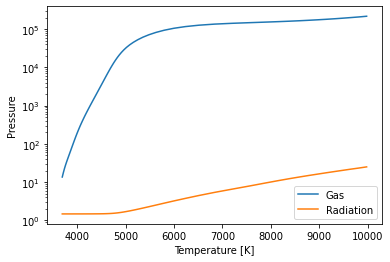

In [9]:
plt.plot(structure['temperature'], structure['gas_pressure'], label = 'Gas')
plt.plot(structure['temperature'], structure['radiation_pressure'], label = 'Radiation')

plt.xlabel('Temperature [{}]'.format(units['temperature']))
plt.ylabel('Pressure'.format(units['gas_pressure']))

plt.yscale('log')
plt.legend()

As expected, gas pressure dominates over radiation pressure by many orders of magnitude for a Sun-like star.

Finally, verify hydrostatic equilibrium:

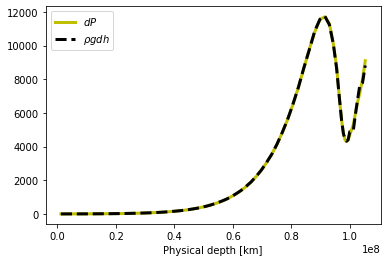

In [10]:
P = structure['gas_pressure'] + structure['radiation_pressure']
dP = P[1:] - P[:-1]

rho = structure['density']
rho = (rho[1:] + rho[:-1]) / 2.0     # Take averages of every pair of elements to ensure the same dimensions

h = structure['physical_depth'] * 1e5    # km to cm
dh = h[1:] - h[:-1]
h = (h[1:] + h[:-1]) / 2.0

plt.plot(h, dP, 'y-', label = '$dP$', lw = 3)
plt.plot(h, rho * g * dh, 'k--', label = r'$\rho g dh$', lw = 3)

plt.xlabel('Physical depth [{}]'.format(units['physical_depth']))
plt.legend()

The atmosphere appears to satisfy the condition of hydrostatic equilibrium closely. Let us now verify energy equilibrium. The outgoing energy flux is composed of convective and radiative components. Plot both below for comparison:

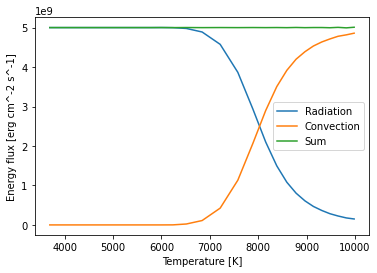

In [11]:
plt.plot(structure['temperature'], structure['radiative_flux'], label = 'Radiation')
plt.plot(structure['temperature'], structure['convective_flux'], label = 'Convection')
plt.plot(structure['temperature'], structure['radiative_flux'] + structure['convective_flux'], label = 'Sum')

plt.xlabel('Temperature [{}]'.format(units['temperature']))
plt.ylabel('Energy flux [{}]'.format(units['radiative_flux']))
plt.legend()

The total flux appears to be nearly constant at the following value:

In [12]:
mean_flux = np.mean(structure['radiative_flux'] + structure['convective_flux'])
print('Mean flux: {:.5e} {}'.format(mean_flux, units['radiative_flux']))

Mean flux: 5.00107e+09 erg cm^-2 s^-1


This constant value must be matched by Stefan-Boltzmann law:

$$F_\mathrm{sum}=\frac{4\sigma}{\pi} T^4_\mathrm{eff}$$

where $F_\mathrm{sum}$ is the sum of fluxes above and $\sigma$ is the Stefan-Boltzmann constant. The effective temperature is available in the meta data as before:

In [13]:
teff = atlas.meta(run_dir)['teff']
print('Effective temperature: {} m s^-2'.format(g))

Effective temperature: 27542.28703338169 m s^-2


Now calculate the Stefan-Boltzmann prediction for $F_\mathrm{sum}$:

In [14]:
sigma = 5.670374e-5            # Stefan-Boltzmann constant in CGS
Fsum = sigma * teff ** 4.0 / (4 * np.pi)
print('Stefan-Boltzmann flux: {:.5e} {}'.format(Fsum, units['radiative_flux']))

Stefan-Boltzmann flux: 5.00156e+09 erg cm^-2 s^-1


The correspondence between the two values is good but not perfect. The difference is known as the *flux error* which is also provided as a percentage value in `structure`:

Text(0, 0.5, 'Flux error [%]')

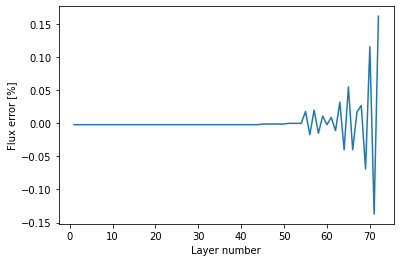

In [15]:
plt.plot(structure['layer'], structure['flux_error'])
plt.xlabel('Layer number')
plt.ylabel('Flux error [%]')

The flux errors are reasonably small but may be improved further with more iterations.

Finally, let us check that the calculated structure satisfies the relationship between Rosseland optical depth ($\tau_R$) and Rosseland mean opacity ($\kappa_R$):

$$d\tau_R=\kappa_R \rho dh$$

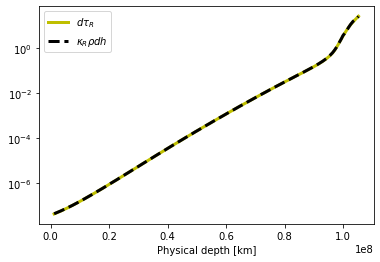

In [16]:
tau_r = structure['rosseland_optical_depth']
kappa_r = structure['rosseland_opacity']

dtau_r = tau_r[1:] - tau_r[:-1]
kappa_r = (kappa_r[1:] + kappa_r[:-1]) / 2.0

plt.plot(h, dtau_r, 'y-', label = r'$d\tau_R$', lw = 3)
plt.plot(h, kappa_r * rho * dh, 'k--', label = r'$\kappa_R \rho dh$', lw = 3)

plt.xlabel('Physical depth [{}]'.format(units['physical_depth']))
plt.legend()
plt.yscale('log')

## Spectrum

Read the synthetic spectrum from a successful `SYNTHE` run with `atlas.read_spectrum()`:

In [17]:
# Bin the spectrum into 1000 uniform wavelength intervals for visualization purposes
spectrum = atlas.read_spectrum(run_dir, num_bins = 1000)

Synthetic spectra have $\mathrm{A}$ as wavelength units and $\mathrm{erg}\ \mathrm{s}^{-1}\ \mathrm{cm}^{-2}\ \mathrm{A}^{-1}\ \mathrm{strad}^{-1}$ as flux units. The `spectrum` dictionary defined above contains both the synthesized flux and its continuum constituent:

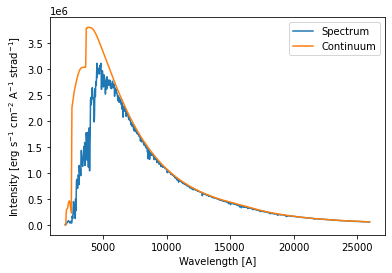

In [18]:
plt.plot(spectrum['wl'], spectrum['flux'], label = 'Spectrum')
plt.plot(spectrum['wl'], spectrum['cont'], label = 'Continuum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')
plt.legend()

The ratio of the two fluxes stored in the `line` key of the dictionary emphasizes line absorption in the atmosphere:

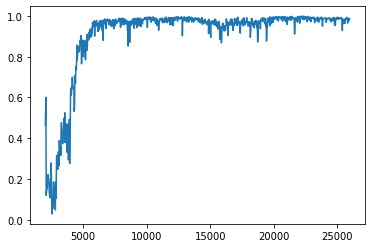

In [19]:
plt.plot(spectrum['wl'], spectrum['line'], label = 'Spectrum')

Now plot the calculated spectrum with the blackbody Planck profile corresponding to the same effective temperature:

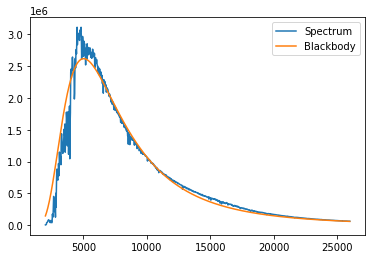

In [20]:
# Planck blackbody profile
def planck(wl, T):
    h = 6.62607015e-34      # Planck constant
    c = 3e8                 # Speed of light
    k = 1.380649e-23        # Boltzmann constant
    wl = wl * 1e-10         # Angstrums to metres
    result = 2.0 * h * c ** 2 / ((wl ** 5) * (np.exp(h * c / (wl * k * T)) - 1.0))

    # Output in CGS
    return result * 1e-7

plt.plot(spectrum['wl'], spectrum['flux'], label = 'Spectrum')
plt.plot(spectrum['wl'], planck(spectrum['wl'], teff), label = 'Blackbody')
plt.legend()